# Dog Breed CNN Classification with TensorFlow

## Импорт библиотек

In [16]:
import shutil
import zipfile
import os

from google.colab import drive
from PIL import Image
import tensorflow as tf
import numpy as np
from tensorflow import keras
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

tf.test.gpu_device_name()

'/device:GPU:0'

## Подключение GoogleDrive (Для Google Colab)

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


## Загрузка набора данных из GoogleDrive

In [3]:
zip_file_path = '/content/drive/MyDrive/Datasets/DogBreeds.zip'
shutil.copy(zip_file_path, '/content/')

unzip_dir = '/content/DogBreeds/'
with zipfile.ZipFile('/content/DogBreeds.zip', 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

print(os.listdir(unzip_dir))

['test', 'train', 'sample_submission.csv', 'labels.csv']


## Предпросмотр данных

Просмотр csv-файла

In [6]:
df = pd.read_csv('/content/DogBreeds/labels.csv')
df['filepath'] = '/content/DogBreeds/train/' + df['id'] + '.jpg'
df.head()

,id,breed,filepath
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,/content/DogBreeds/train/000bec180eb18c7604dce...
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,/content/DogBreeds/train/001513dfcb2ffafc82ccc...
2,001cdf01b096e06d78e9e5112d419397,pekinese,/content/DogBreeds/train/001cdf01b096e06d78e9e...
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,/content/DogBreeds/train/00214f311d5d2247d5dfe...
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,/content/DogBreeds/train/0021f9ceb3235effd7fcd...


Оценка количества изображений

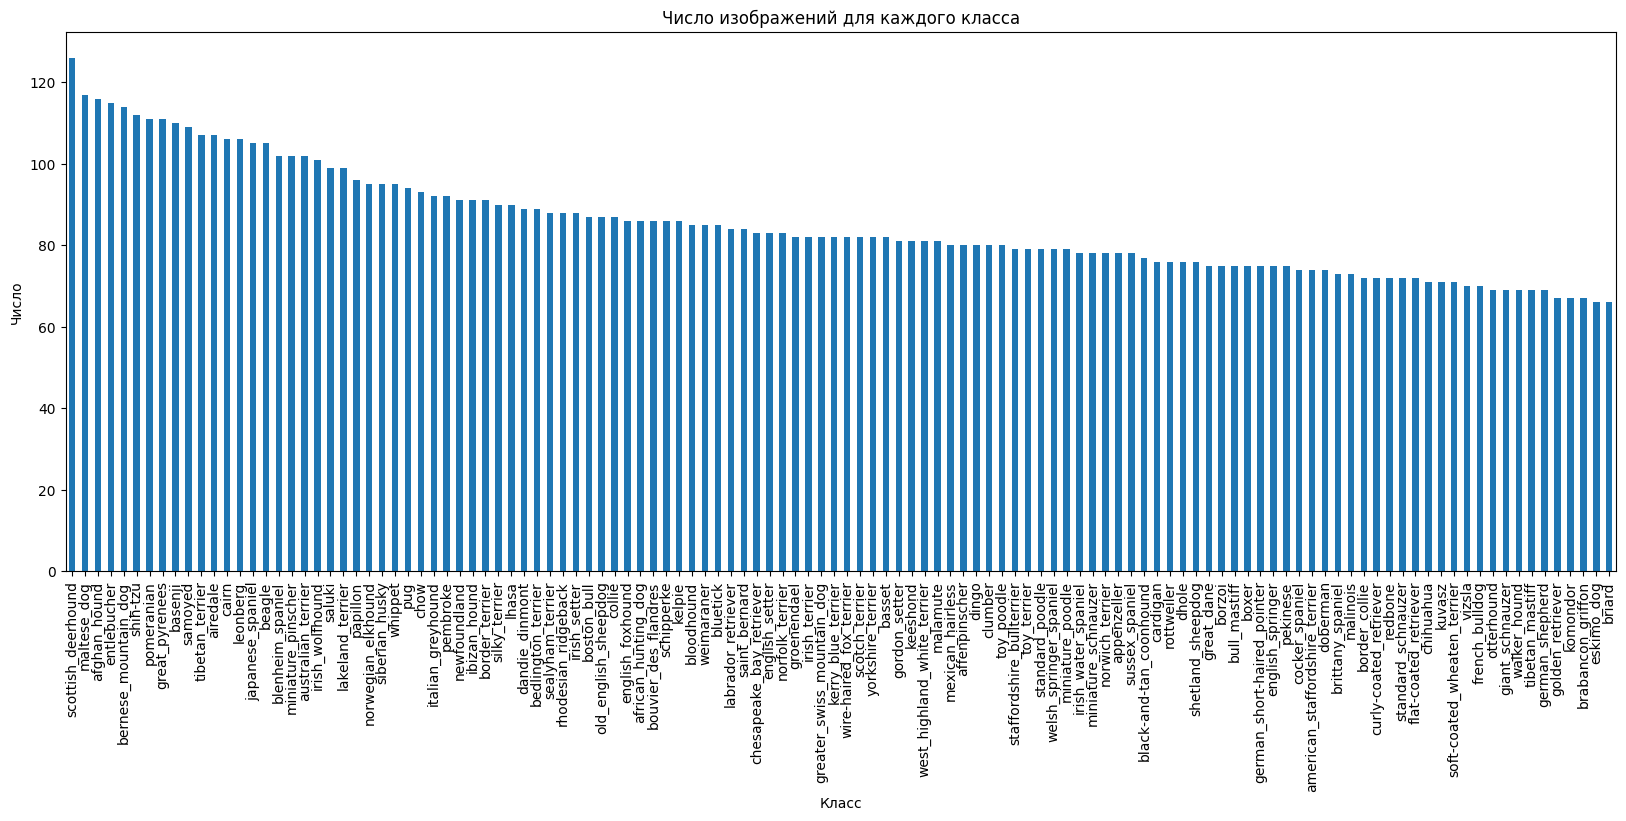

In [11]:
plt.figure(figsize=(20, 7))
df['breed'].value_counts().plot.bar()
plt.title('Число изображений для каждого класса')
plt.xlabel('Класс')
plt.ylabel('Число')
plt.show()

Предпросмотр случайных изображений

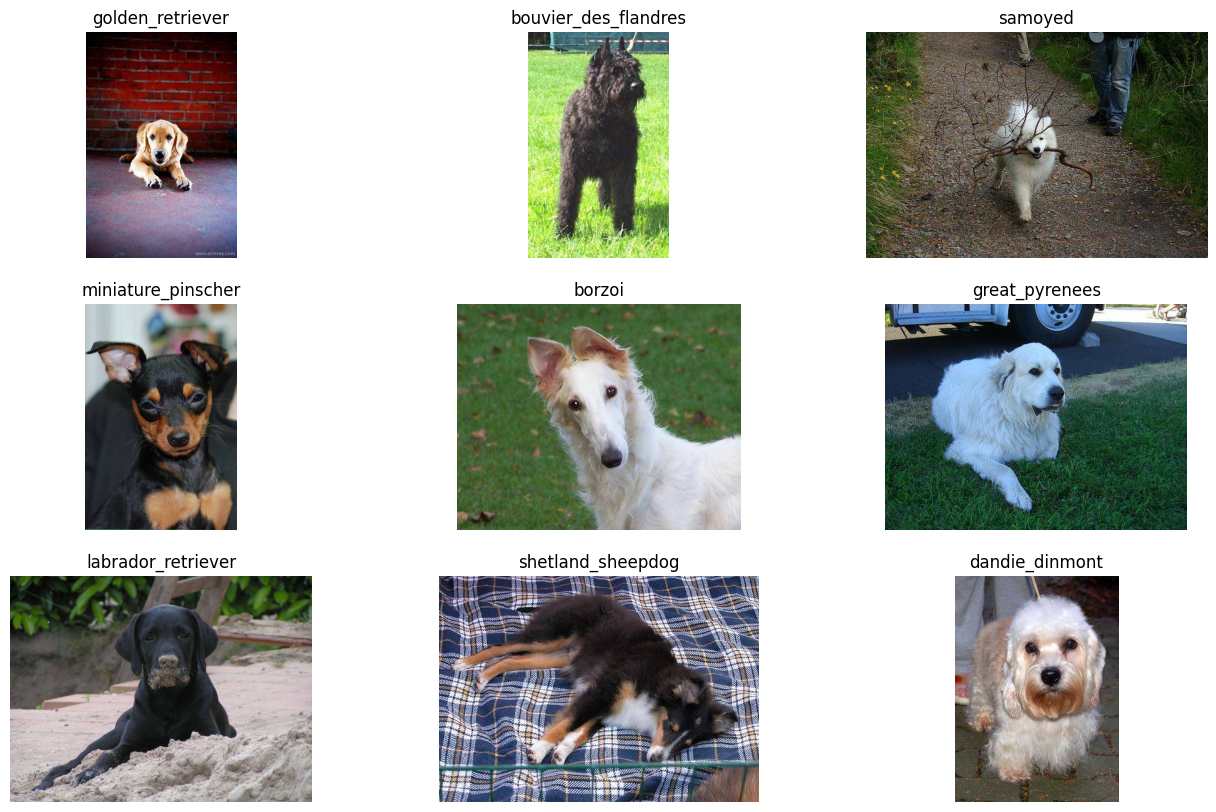

In [12]:
plt.figure(figsize=(16, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    k = np.random.randint(0, len(df))
    img = Image.open(df.loc[k, 'filepath'])
    plt.imshow(img)
    plt.title(df.loc[k, 'breed'])
    plt.axis('off')

plt.show()

## Загрузка данных

In [28]:
# Кодирование пород числом
LE = LabelEncoder()
df['breed'] = LE.fit_transform(df['breed'])

features = df['filepath']
target = df['breed']

x_train, x_val, y_train, y_val = train_test_split(features, target, test_size=0.15, random_state=10)


def decode_image(filepath, label=None):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image)
    image = tf.image.resize(image, (128, 128))
    image = tf.cast(image, tf.float32) / 255.0

    if label is None:
        return image

    label = tf.one_hot(label, depth=120, dtype=tf.float32)
    return image, label


train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .map(decode_image)
    .batch(32)
)

validation_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_val, y_val))
    .map(decode_image)
    .batch(32)
)

for image, label in train_dataset.take(1):
    print(f'Форма пакета изображений: {image.shape}, Форма пакета меток: {label.shape}')

Форма пакета изображений: (32, 128, 128, 3), Форма пакета меток: (32, 120)


## Построение модели

In [30]:
inception_v3 = keras.applications.InceptionV3(
    input_shape=(128, 128, 3),
    weights = 'imagenet',
    include_top = False
)

for layer in inception_v3.layers:
    layer.trainable = False

data_augmentation = keras.Sequential([
    keras.layers.RandomFlip('horizontal'),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.2)
])

last_layer = inception_v3.get_layer('mixed7')
print(f'Вывод последнего слоя: {last_layer.output.shape}')
last_output = last_layer.output

inputs = keras.Input(shape=(128, 128, 3))
x = inception_v3(inputs)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation = 'relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(256, activation = 'relu')(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.BatchNormalization()(x)
outputs = keras.layers.Dense(120, activation = 'softmax')(x)

model = keras.Model(inputs, outputs)

Вывод последнего слоя: (None, 6, 6, 768)


## Компиляция модели

In [41]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['AUC']
)

## Создание обратных вызовов

In [42]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)
    return exponential_decay_fn


exp_decay_fn = exponential_decay(0.01, 20)

callbacks = [
    keras.callbacks.LearningRateScheduler(exp_decay_fn),
    keras.callbacks.ModelCheckpoint(
        '/content/drive/MyDrive/Models/dogbreeds.keras',
        save_best_only=True),
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
]

## Обучение модели

In [43]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 44s 112ms/step - AUC: 0.9901 - loss: 0.7330 - val_AUC: 0.8591 - val_loss: 3.5337 - learning_rate: 0.0100
Epoch 2/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 16s 57ms/step - AUC: 0.9933 - loss: 0.6565 - val_AUC: 0.8377 - val_loss: 4.0185 - learning_rate: 0.0089
Epoch 3/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - AUC: 0.9954 - loss: 0.5313 - val_AUC: 0.8335 - val_loss: 4.0869 - learning_rate: 0.0079
Epoch 4/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - AUC: 0.9972 - loss: 0.4133 - val_AUC: 0.8243 - val_loss: 4.3360 - learning_rate: 0.0071
Epoch 5/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - AUC: 0.9976 - loss: 0.3383 - val_AUC: 0.8211 - val_loss: 4.4329 - learning_rate: 0.0063
Epoch 6/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - AUC: 0.9980 - loss: 0.2450 - val_AUC: 0.8246 - val_loss: 4.9255 - learning_rate: 0.0056
Epoch 7/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - AUC: 0.9983 - loss: 0.1950 - val_AUC: 0.8193 - val_loss: 4.9938 - learning_rate

## Визуализация обучения

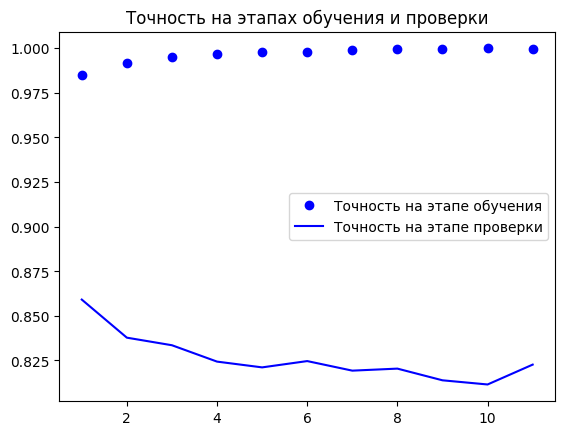

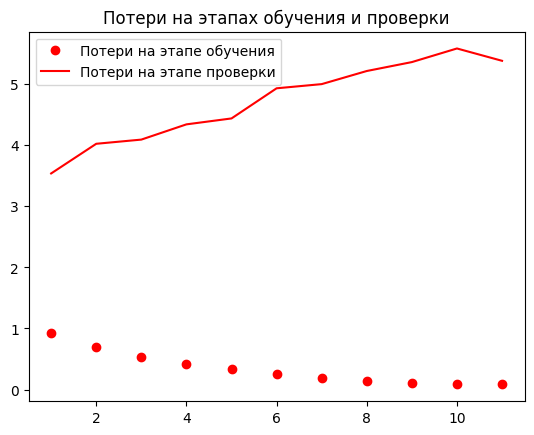

In [45]:
accuracy = history.history['AUC']
val_accuracy = history.history['val_AUC']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'bo', label='Точность на этапе обучения')
plt.plot(epochs, val_accuracy, 'b', label='Точность на этапе проверки')
plt.title('Точность на этапах обучения и проверки')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'ro', label='Потери на этапе обучения')
plt.plot(epochs, val_loss, 'r', label='Потери на этапе проверки')
plt.title('Потери на этапах обучения и проверки')
plt.legend()
plt.show()